# Twitter Trading Strategy
Letting Tweet Sentiment determine buy, sell, or holds.

In [4]:
# Libraries
import twint
import nest_asyncio
nest_asyncio.apply()
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import plotly.express as px
import yfinance as yf
import numpy as np

# Helper Functions
Getting prices and Tweets

## Twint Query Function

In [5]:
def getTweets(search_term, until, limit=20):
    """
    Configures Twint and returns a dataframe of tweets for a specific day.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True
    
    # Popular tweets
    c.Popular_tweets = True

    # Lowercasing tweets
    c.Lowercase = True

    # English only
    c.Lang = 'en'

    # Tweets until a specified date
    c.Until = until + " 00:00:00"
    
    # Making the results pandas friendly
    c.Pandas = True
    
    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)
    
    # Assigning the DF
    df = twint.storage.panda.Tweets_df
    
    # Returning an empty DF if no tweets were found
    if len(df)<=0:
        return pd.DataFrame()
    
    # Formatting the date
    df['date'] = df['date'].apply(lambda x: x.split(" ")[0])
    
    return df

## Twint over Time Function

In [6]:
def tweetByDay(start, end, df, search, limit=20):
    """
    Runs the twint query everyday between the given dates and returns
    the total dataframe.
    """
    # Finishing the recursive loop
    if start==end:
        # Removing any potential duplicates
        df = df.drop_duplicates(subset="id")
        print(f"Complete! {len(df)} tweets collected")
        return df
    
    # Appending the new set of tweets for the day
    tweet_df = getTweets(search, end, limit)
    
    # Running the query a few more times in case twint missed some tweets
    run = 0 
    
    while len(tweet_df)==0 or run<=2:
        # Running query again
        tweet_df = getTweets(search, end, limit)
        
        # Counting how many times it ran
        run += 1
    
    # Adding the new tweets
    df = df.append(tweet_df, ignore_index=True)
    
    # Updating the new end date
    new_end = (datetime.strptime(end, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    
    # Printing scraping status
    print(f"\t{len(df)} Total Tweets collected as of {new_end}\t")
    
    # Running the function again
    return tweetByDay(start, new_end, df, search)

## Sentiment Function

In [7]:
def getSentiment(df, measurement="compound"):
    """
    Given a DF of tweets, analyzes the tweets and returns a new DF
    of sentiment scores based on the given measurement.
    Accepted sentiment measurements: ["pos", "neg", "neu", "compound"]
    """

    # Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # Getting the sentiment score
    df['sentiment'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)[measurement])

    # Creating a DF with the average sentiment score each day
    sent_df = df.groupby('date')['sentiment'].mean().reset_index()
    
    # Converting the dates to datetime
    sent_df['date'] = sent_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    
    return sent_df

## Price Data Function

In [8]:
def getStockPrices(ticker, start, end):
    """
    Gets the historical daily prices between two dates. Scaling the prices based on a
    given sentiment dataframe.
    """
    # Setting the stock
    stock = yf.Ticker(ticker)

    # Getting historical prices
    stock_df = stock.history(start=end, end=start, interval="1d")[['Close']]
        
    # Getting the daily log returns
    stock_df = stock_df.apply(np.log).diff().dropna()
    
    # Some reformatting
    stock_df = stock_df.reset_index().rename(
        columns={
            "Date": "date",
            "Close": "log returns"
        }
    )
    
    return stock_df

## Sentiment and Price Function

In [9]:
def sentimentAndPrice(ticker, start, end, numtweets=20):
    """
    Visually compares sentiment with the closing price of a given stock ticker.
    """
    # Creating a DF that contains daily tweets between two dates
    df = tweetByDay(start, end, pd.DataFrame(), search="$"+ticker, limit=numtweets)
        
    # Analyzing the sentiment of each tweet
    sent_df = getSentiment(
        df, 
        measurement='compound'
    )
    
    # Getting stock price history
    stock_df = getStockPrices(
        ticker, 
        start, 
        end
    )
    
    # Merging the two DF
    comb_df = sent_df.merge(stock_df, how='outer', sort=True)
    
    # Shifting the sentiment scores 1 day to compensate for lookahead bias
    comb_df['sentiment'] = comb_df['sentiment'].shift(1)
    
    # Filling the nans with zeroes
    comb_df = comb_df.fillna(0)
    
    # Setting the index
    comb_df.set_index('date', inplace=True)

    return comb_df

## Get Positions Function

In [10]:
def getPositions(val, thres=.01, short=True):
    """
    Provided a specific sentiment value, will return 1, 0, or -1 representing
    buy, hold, or sell respectively. The threshold will determined how high or low the score 
    needs to be to trigger a buy or sell, otherwise it will be a hold.
    """
    
    # Sentiment score threshold
    thres = .01
    
    # Shorting ability
    short = True
    
    # Getting positions
    if val > thres:
        return 1
    elif val < -thres and short:
        return -1
    else:
        return 0

## Vectorize Backtesting Function

In [37]:
def vectBacktest(df, thres=.01, short=True):
    """
    Accepts a dataframe of sentiment and log returns. Returns a series of the
    portfolio performance from the backtest.
    """
    
    # Getting the initial positions
    df['positions'] = df['sentiment'].apply(lambda x: getPositions(x,
                                                                   thres=thres,
                                                                   short=short))
    
    # Performing the backtest
    returns = df['positions'] * df['log returns']
    
    # Inversing the log returns and getting daily portfolio balance
    performance = returns.cumsum().apply(np.exp)
    
    # Returning the daily returns and the portfolio performance
    return performance

# Running the Function

In [38]:
# Time periods
now = datetime.now()

# How far back to retrieve tweets
ago = now - timedelta(days=10)

# DF for sentiment and log returns
df = sentimentAndPrice(
    "AMC", 
    now.strftime("%Y-%m-%d"), 
    ago.strftime("%Y-%m-%d"), 
    numtweets=20
)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


KeyboardInterrupt: 

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


# Performing the Backtest

In [30]:
performance = vectBacktest(df)

performance

date
2021-08-29    1.000000
2021-08-30    1.000000
2021-08-31    1.087699
2021-09-01    1.008308
2021-09-02    1.024233
2021-09-03    1.015924
2021-09-04    1.015924
2021-09-05    1.015924
2021-09-06    1.015924
2021-09-07    1.015924
2021-09-08    1.006791
dtype: float64

# Visualizing the Results

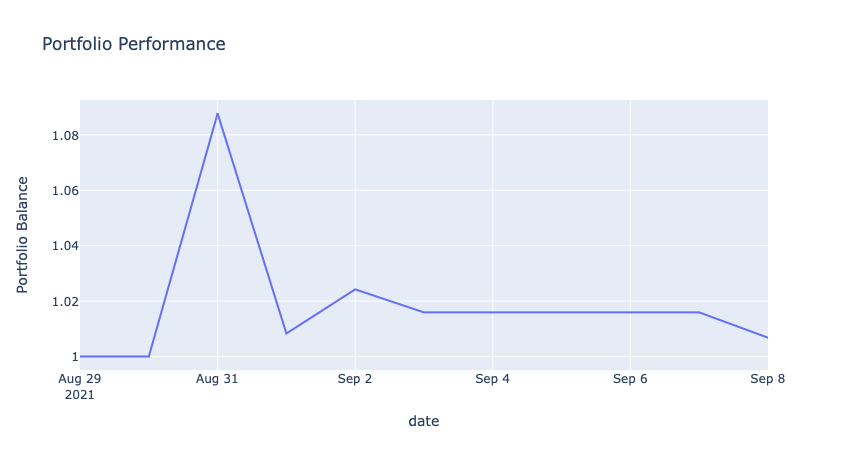

In [43]:
px.line(performance,
        x=performance.index,
        y=performance,
        title='Portfolio Performance',
        labels={"y": "Portfolio Balance"})

# Backtesting Multiple Stocks

In [40]:
# The list of chosen stocks
tickers = ["AMC", "GME", "PLTR", "SPCE"]

# Time periods
now = datetime.now()

# How far back to retrieve tweets
ago = now - timedelta(days=14)

# Individual stock df
stock_df = pd.DataFrame()

# Iterating through each ticker
for ticker in tickers:
    
    print(f"Starting {ticker}")
    # DF for sentiment and log returns
    sentiment = sentimentAndPrice(
        ticker, 
        now.strftime("%Y-%m-%d"), 
        ago.strftime("%Y-%m-%d"), 
        numtweets=20
    )
    
    # Getting the backtest results for an individual stock
    stock_perf = vectBacktest(sentiment)

    # Adding this performance to the stock's df
    stock_df[ticker] = stock_perf

Starting AMC
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	20 Total Tweets collected as of 2021-08-27	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	40 Total Tweets collected as of 2021-08-28	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	59 Total Tweets collected as of 2021-08-29	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
	95 Total Tweets collected as of 2021-08-30	
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this searc

# Visualizing the results for Multiple Stocks

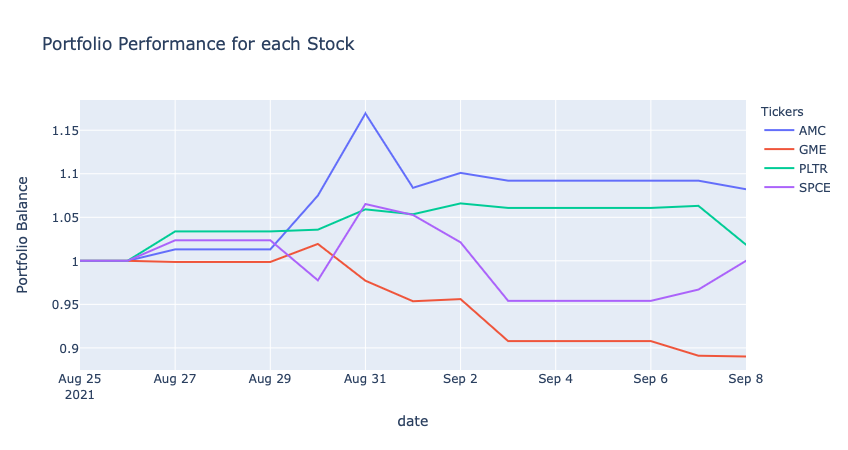

In [41]:
px.line(stock_df,
        x=stock_df.index,
        y=stock_df.columns,
        title='Portfolio Performance for each Stock',
        labels={"value": "Portfolio Balance",
                "variable": "Tickers"})

## Overall Performance
With the above stocks

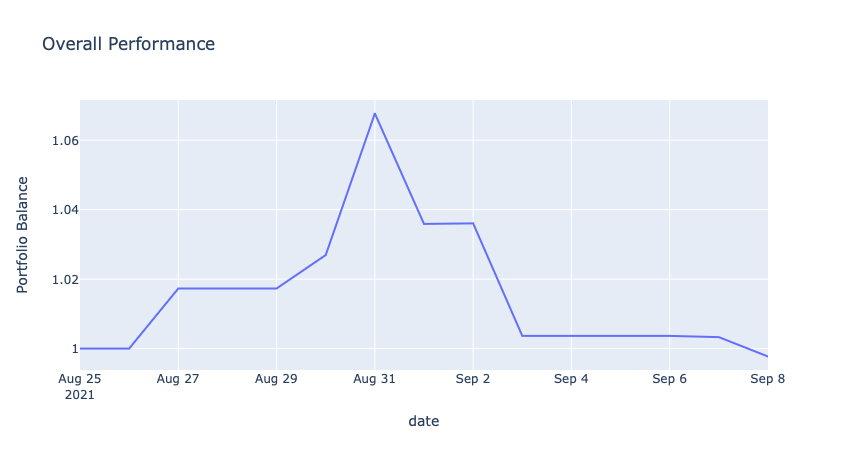

In [46]:
# Getting the overall performance for all stocks
portfolio = stock_df.apply(lambda x: x/len(tickers)).sum(axis=1)

# Visualizing the overall portfolio
px.line(portfolio,
        x=portfolio.index,
        y=portfolio,
        title='Overall Performance',
        labels={"y": "Portfolio Balance"})